# Planetary Nebula Production <a class="tocSkip">
    
This notebook is used to test and showcase the results of my first project. I use spectroscopic data from the [Multi Unit Spectroscopic Explorer](https://www.eso.org/sci/facilities/develop/instruments/muse.html) (MUSE) that has been observed as part of the [PHANGS](https://sites.google.com/view/phangs/home) collaboration.
    
I will use a set of line maps of emission lines to identify Planetary Nebula in the data an measure their brightness. This can then be used to fit an empiric relation and hence measure the distance to the galaxy.
    
This notebook is used for developement. Final code is moved to the `pymuse` packge in the `src` folder. Any production scripts reside in the `scripts` folder.

## Preparation
 
### Load Basic Packages
    
First we load a bunch of common packages that are used across the project. More specific packages that are only used in one section are loaded later to make it clear where they belong to (this also applies to all custom moduls that were written for this project).

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

# some basic packages
import os                 # filesystem related stuff
import json
from pathlib import Path  # use instead of os.path and glob
import sys                # mostly replaced by pathlib

import errno      # more detailed error messages
import warnings   # handles warnings
import logging    # use logging instead of print

from collections import OrderedDict  

# packages for scientific computing
import numpy as np
import scipy as sp

# packages for creating plots and figures
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# special functions for astronomy 
from astropy.table import Table  # useful datastructure
from astropy.table import vstack # combine multiple tables

from astropy.io import fits      # open fits files
from astropy.io import ascii     # handle normal files

from astropy.wcs import WCS               # handle coordinates
from astropy.coordinates import SkyCoord  # convert pixel to sky coordinates
from astropy.visualization import simple_norm

from astropy.stats import sigma_clipped_stats  # calcualte statistics of images

import astropy.units as u        # handle units

tab10 = ['#e15759','#4e79a7','#f28e2b','#76b7b2','#59a14e','#edc949','#b07aa2','#ff9da7','#9c755f','#bab0ac']    
plt.style.use('TeX.mplstyle')

we use the `logging` module to handle informations and warnings (this does not always work as expected in jupyter notebooks).

In [2]:
logging.basicConfig(stream=sys.stdout,
                    #format='(levelname)s %(name)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

logger = logging.getLogger(__name__)

In [5]:
# first we need to specify the path to the raw data
data_raw = Path('d:\downloads\MUSEDAP')
basedir = Path('..')

galaxies = [x.name for x in data_raw.iterdir() if x.is_dir()]

with open(basedir / 'data' / 'interim' / 'parameters.json') as json_file:
    parameters = json.load(json_file)

## Plot all objects in one figure

### Measure distance to all objects

In [7]:
from pymuse.analyse import MaximumLikelihood1D, pnlf

distances_measured = {}
for name in galaxies:
    
    completeness = parameters[name]['completeness_limit']
    
    filename = basedir / 'data' / 'catalogues' / f'pn_candidates_{name}.txt'
    tbl = ascii.read(str(filename),format='fixed_width',delimiter='\t')
    data = tbl[(tbl['type']=='PN') & (tbl['mOIII']<completeness)]['mOIII']
    err  = tbl[(tbl['type']=='PN') & (tbl['mOIII']<completeness)]['dmOIII']
    #data = data[data>26]
    
    if 'cut' in parameters[name]:
        print(f'removing points brighter than {parameters[name]["cut"]}')
        data = data[data>parameters[name]['cut']]
    
    fitter = MaximumLikelihood1D(pnlf,
                                 data[data<completeness],
                                 mhigh=completeness)
    
    # a good guess would be mu_guess = min(data)-Mmax
    distances_measured[name] = fitter([24])
    

INFO:pymuse.analyse:initialize fitter with 42 data points


d:\documents\university\phd\pymuse\src\pymuse\analyse.py:336: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(ev))


INFO:pymuse.analyse:initialize fitter with 33 data points
removing points brighter than 23
INFO:pymuse.analyse:initialize fitter with 344 data points
INFO:pymuse.analyse:initialize fitter with 46 data points
INFO:pymuse.analyse:initialize fitter with 72 data points
removing points brighter than 25.5
INFO:pymuse.analyse:initialize fitter with 43 data points
INFO:pymuse.analyse:initialize fitter with 41 data points
INFO:pymuse.analyse:initialize fitter with 95 data points
INFO:pymuse.analyse:initialize fitter with 66 data points
removing points brighter than 25.5
INFO:pymuse.analyse:initialize fitter with 34 data points
INFO:pymuse.analyse:initialize fitter with 64 data points
INFO:pymuse.analyse:initialize fitter with 71 data points
INFO:pymuse.analyse:initialize fitter with 96 data points


In [8]:
from pymuse.auxiliary import Distance

for k,v in distances_measured.items():
    mu, mp, mm = v
    mu_pc = Distance(mu,'mu').to_parsec()/1e6
    mp_pc = 0.2*np.log(10) * mu_pc * mp
    mm_pc = 0.2*np.log(10) * mu_pc * mm
    print(f'{k} & $\\uncertainty{{{mu:.3f}}}{{{mp:.3f}}}{{{mm:.3f}}}$ & $\\uncertainty{{{mu_pc:.3f}}}{{{mp_pc:.3f}}}{{{mm_pc:.3f}}}$ \\\\')

IC5332 & $\uncertainty{29.620}{0.043}{0.259}$ & $\uncertainty{8.393}{0.166}{1.002}$ \\
NGC1087 & $\uncertainty{30.546}{0.049}{0.263}$ & $\uncertainty{12.857}{0.290}{1.559}$ \\
NGC1365 & $\uncertainty{27.536}{0.023}{0.113}$ & $\uncertainty{3.215}{0.034}{0.167}$ \\
NGC1512 & $\uncertainty{30.858}{0.015}{0.117}$ & $\uncertainty{14.847}{0.103}{0.801}$ \\
NGC1566 & $\uncertainty{30.034}{0.041}{0.133}$ & $\uncertainty{10.158}{0.192}{0.623}$ \\
NGC1672 & $\uncertainty{30.254}{0.037}{0.223}$ & $\uncertainty{11.242}{0.192}{1.156}$ \\
NGC2835 & $\uncertainty{29.734}{0.015}{0.163}$ & $\uncertainty{8.847}{0.061}{0.665}$ \\
NGC3351 & $\uncertainty{30.036}{0.033}{0.115}$ & $\uncertainty{10.168}{0.155}{0.539}$ \\
NGC3627 & $\uncertainty{29.544}{0.029}{0.171}$ & $\uncertainty{8.105}{0.108}{0.639}$ \\
NGC4254 & $\uncertainty{30.297}{0.031}{0.219}$ & $\uncertainty{11.467}{0.164}{1.158}$ \\
NGC4535 & $\uncertainty{31.110}{0.023}{0.113}$ & $\uncertainty{16.670}{0.177}{0.868}$ \\
NGC5068 & $\uncertainty{28

### Plot PNLF

C:\tools\anaconda3\envs\pymuse\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.


removing points brighter than 23
removing points brighter than 25.5
removing points brighter than 25.5


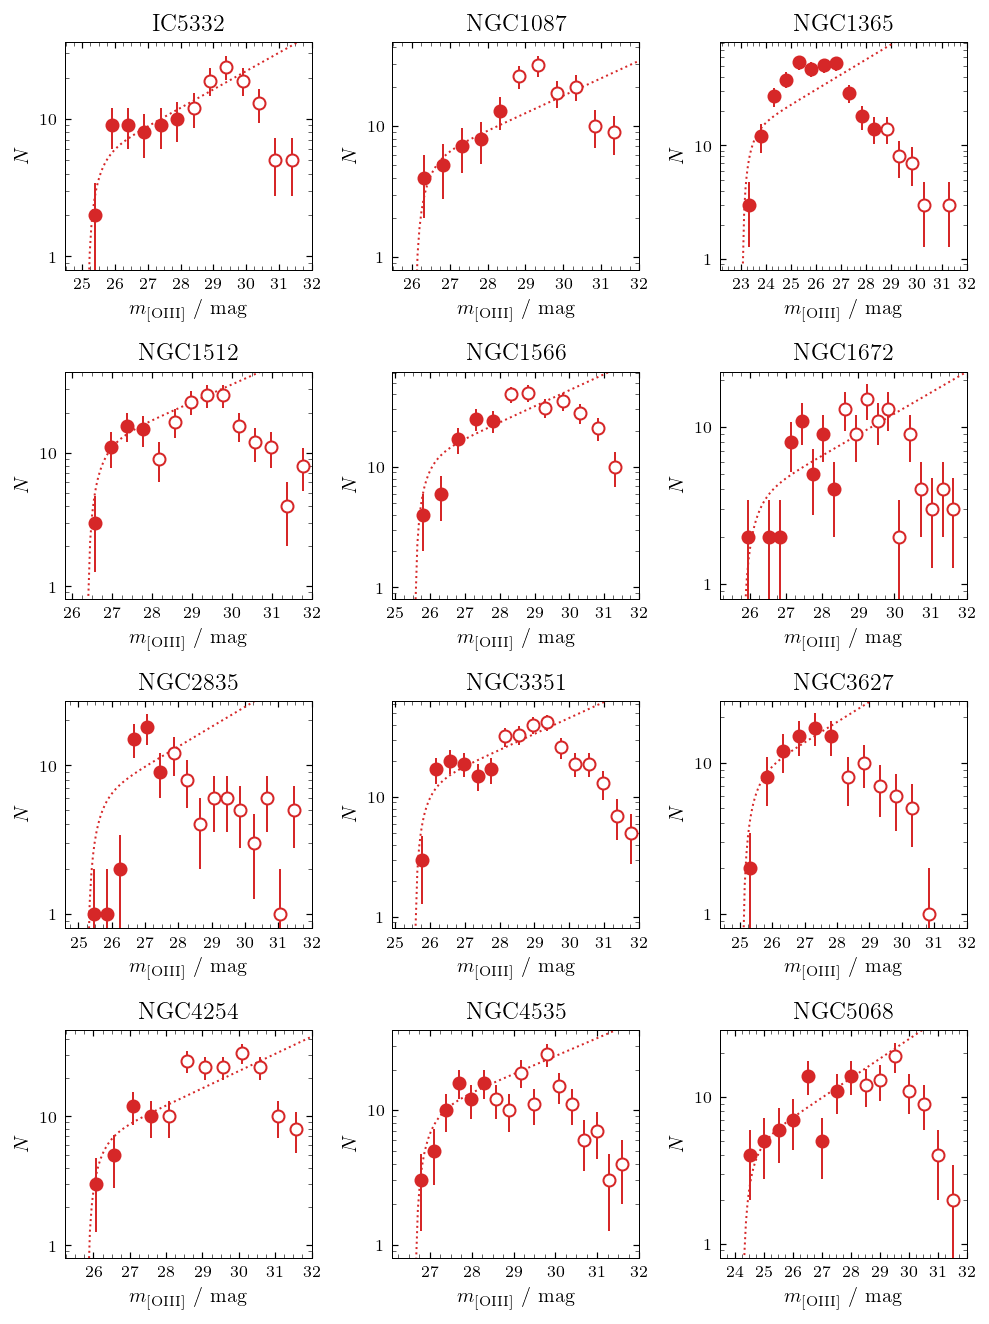

In [10]:
from pymuse.analyse import MaximumLikelihood1D, PNLF, pnlf

Mmax = -4.47
names = galaxies
#names = ['IC5332', 'NGC1087', 'NGC1365', 'NGC1512', 'NGC1672', 'NGC2835', 'NGC3351', 'NGC3627', 'NGC4254', 'NGC4535', 'NGC5068', 'NGC628']
color = 'tab:red'

fig, axes = plt.subplots(nrows=4,ncols=3,figsize=(6.974,6.974/3*4))

for i, ax in enumerate(fig.axes):
    
    if i < len(names):
        name = names[i]
    else:
        break
        
    if 'binsize' in parameters[name]:
        binsize=parameters[name]['binsize']
    else:
        binsize=0.4
    
    completeness = parameters[name]['completeness_limit']
    
    filename = basedir / 'data' / 'catalogues' / f'pn_candidates_{name}.txt'
    tbl = ascii.read(str(filename),format='fixed_width',delimiter='\t')
    data = tbl[(tbl['type']=='PN')]['mOIII']
    err  = tbl[(tbl['type']=='PN')]['dmOIII']
    
    if 'cut' in parameters[name]:
        print(f'removing points brighter than {parameters[name]["cut"]}')
        data = data[data>parameters[name]['cut']]

    mu,dp,dm = distances_measured[name]
        
    mlow = Mmax+mu
    mhigh = 32

    N = len(data[data<completeness])
    
    hist, bins  = np.histogram(data,np.arange(mlow,mhigh,binsize),normed=False)
    err = np.sqrt(hist)
    # midpoint of the bins is used as position for the plots
    m = (bins[1:]+bins[:-1]) / 2
    
    # for the fit line we use a smaller binsize
    binsize_fine = 0.05
    bins_fine = np.arange(mlow,mhigh,binsize_fine)
    m_fine = (bins_fine[1:]+bins_fine[:-1]) /2

    # scatter plot
    ax.errorbar(m[m<completeness],hist[m<completeness],yerr=err[m<completeness],
                 marker='o',ms=6,mec=color,mfc=color,ls='none',ecolor=color)
    ax.errorbar(m[m>=completeness],hist[m>=completeness],yerr=err[m>completeness],
                 marker='o',ms=6,mec=color,mfc='white',ls='none',ecolor=color)
    ax.plot(m_fine,binsize/binsize_fine*N*PNLF(bins_fine,mu=mu,mhigh=completeness),c=color,ls='dotted')
    #ax.axvline(completeness,c='black',lw=0.2)
    #ax.axvline(mu+Mmax,c='black',lw=0.2)

    # adjust plot
    ax.set_yscale('log')
    ax.set_xlim([1.1*mlow-0.1*mhigh,mhigh])
    ax.set_ylim([0.8,1.5*np.max(hist)])
    ax.set_xlabel(r'$m_{[\mathrm{OIII}]}$ / mag')
    ax.set_ylabel(r'$N$')
    
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.2g}'.format(y)))
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
    ax.set_title(name)
    
plt.tight_layout()
filename = basedir / 'reports' / f'all_objects_PNLF'
plt.savefig(filename.with_suffix('.pdf'),bbox_inches='tight')
plt.show()

### Plot cumulative PNLF

C:\tools\anaconda3\envs\pymuse\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.


removing points brighter than 23
removing points brighter than 25.5
removing points brighter than 25.5


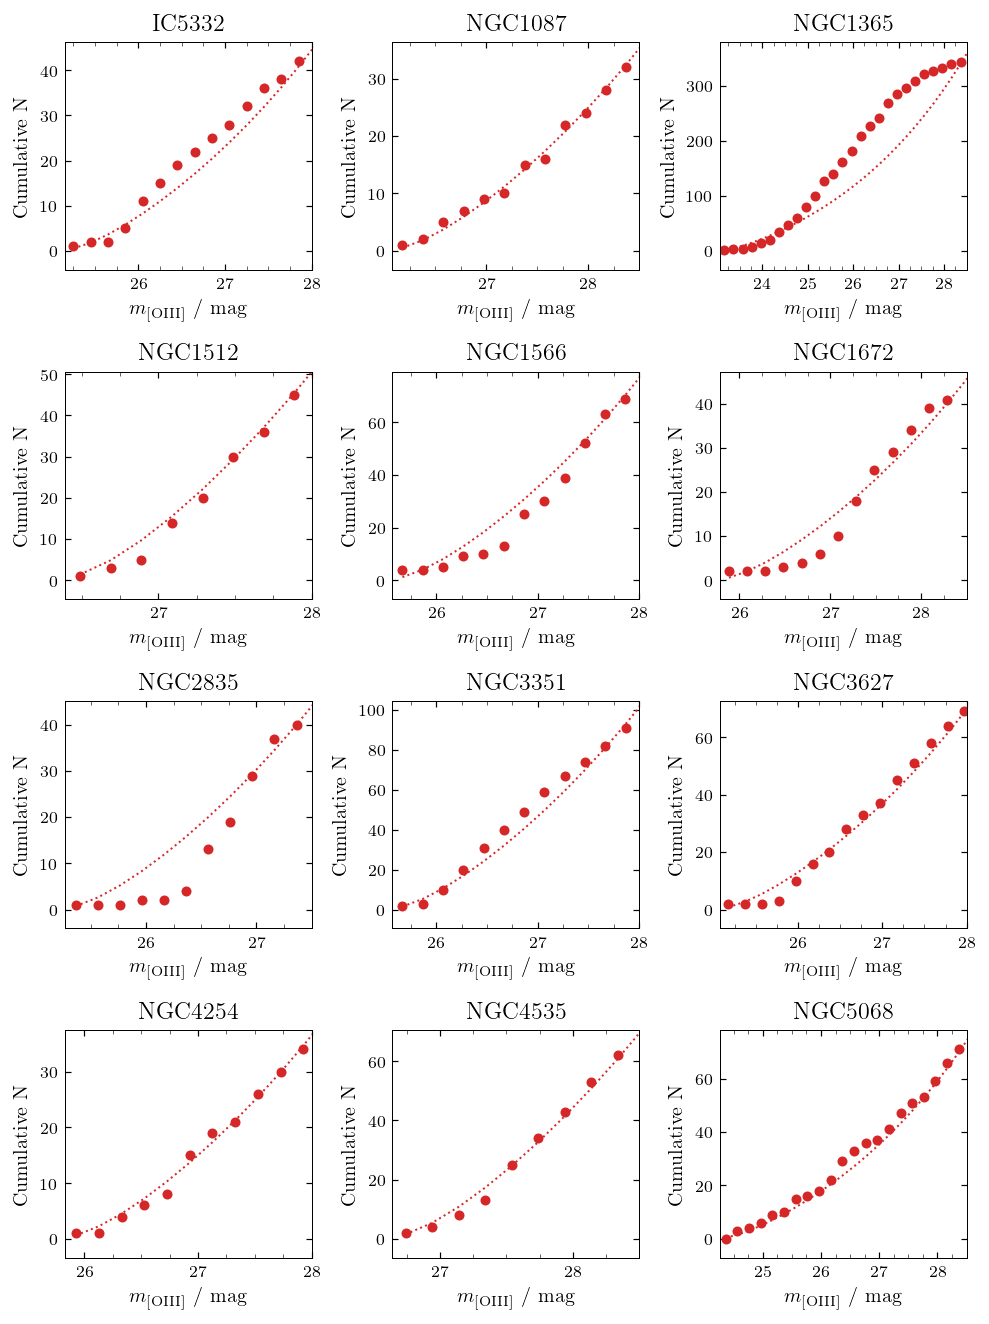

In [11]:
from pymuse.analyse import MaximumLikelihood1D, PNLF, pnlf

binsize=0.2
Mmax = -4.47
color = 'tab:red'

fig, axes = plt.subplots(nrows=4,ncols=3,figsize=(6.974,6.974/3*4))

for i, ax in enumerate(fig.axes):
    
    if i < len(galaxies):
        name = galaxies[i]
    else:
        break
        
    completeness = parameters[name]['completeness_limit']
    
    filename = basedir / 'data' / 'catalogues' / f'pn_candidates_{name}.txt'
    tbl = ascii.read(str(filename),format='fixed_width',delimiter='\t')
    data = tbl[(tbl['type']=='PN')]['mOIII']
    err  = tbl[(tbl['type']=='PN')]['dmOIII']
    #data = data[data>26]

    if 'cut' in parameters[name]:
        print(f'removing points brighter than {parameters[name]["cut"]}')
        data = data[data>parameters[name]['cut']]
    
    mu,dp,dm = distances_measured[name]
    
    mlow = Mmax+mu
    mhigh = 32

    N = len(data[data<completeness])
    
    hist, bins  = np.histogram(data,np.arange(mlow,mhigh,binsize),normed=False)
    err = np.sqrt(hist)
    # midpoint of the bins is used as position for the plots
    m = (bins[1:]+bins[:-1]) / 2
    
    # for the fit line we use a smaller binsize
    binsize_fine = 0.05
    bins_fine = np.arange(mlow,mhigh,binsize_fine)
    m_fine = (bins_fine[1:]+bins_fine[:-1]) /2

    # scatter plot
    ax.plot(m[m<completeness],np.cumsum(hist[m<completeness]),ls='none',mfc=color,mec=color,ms=4,marker='o')
    ax.plot(m,N*np.cumsum(PNLF(bins,mu=mu,mhigh=completeness)),ls='dotted',color=color)

    
    # adjust plot    
    ax.set_xlim([mlow,completeness])
    ax.set_ylim([-0.1*N,1.1*N])
    ax.set_xlabel(r'$m_{[\mathrm{OIII}]}$ / mag')
    ax.set_ylabel(r'Cumulative N')
    
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.0))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.16g}'.format(y)))
    ax.set_title(name)
    
plt.tight_layout()
filename = basedir / 'reports' / f'all_objects_PNLF_cum'
plt.savefig(filename.with_suffix('.pdf'),bbox_inches='tight')
plt.show()